In [1]:
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import sys
# setting path 
sys.path.append('../')
from NeuralNetworks.NNs import FCFF_3L, FCFF_3L_ELU
from PointSampling.Ball import data_gen_ball_unif
from visualization.plots_disc import plot_2d_proj_disc
from visualization.disc_training import plot_2d_proj_w
from Hamiltonians.Eikonal_LxF import Eikonal_sq_LF_multiD
from Hamiltonians.H_Autograd import Eikonal_sq_autograd
from Training.training_finite_sum import train_finite_sum
from error_test.cube_error import FD_loss
from error_test.disc_error import error_ball

dim = 2

radii = [3., 0.]
domain = data_gen_ball_unif(radii, dim)

#Right-hand-side of the PDE
def f(X): return 1

#Boundary condition
def g(X): return 0

# Training parameters: (alpha, delta) for FD Hamiltonians and epsilon for Autograd
delta_list = [.7, .5, .2, .1, .05]
alpha_list = [2., 2., 2., 2., 2.]
epsilon_list = [1., .5, .2, .01, 0.]
rounds = len(delta_list)
training_params = {
    
    'f': f, 
    'g': g, 
    'c': None,
    
    'beta': 0., ## parameter for the +u_i term 
    
    'lambda': 1. #weight parameter for the boundary loss
}

# Test data
x_grid = torch.linspace(-max(radii), max(radii), int(21))
print('delta_test = ', x_grid[1]-x_grid[0] )
X,Y = torch.meshgrid(x_grid, x_grid)
data_square = torch.cat((X.unsqueeze(-1), Y.unsqueeze(-1)), dim = -1).reshape([-1, 2])
test_data = data_square[data_square.norm(dim = -1) < max(radii)]
print('Number of test points =', test_data.shape[0])

n_experiments = 2

delta_test =  tensor(0.3000)
Number of test points = 305


C:\Users\usuario\anaconda3\envs\FD_PINNs\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Fixed collocation points and Lax-Friedrichs numerical Hamiltonian

100%|██████████| 500/500 [00:10<00:00, 47.61it/s]
C:\Users\usuario\Documents\math\project_FD_PINNs\HamiltonJacobi_LeastSquares_LxF_NNs\Notebooks_revised\..\visualization\disc_training.py:48: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


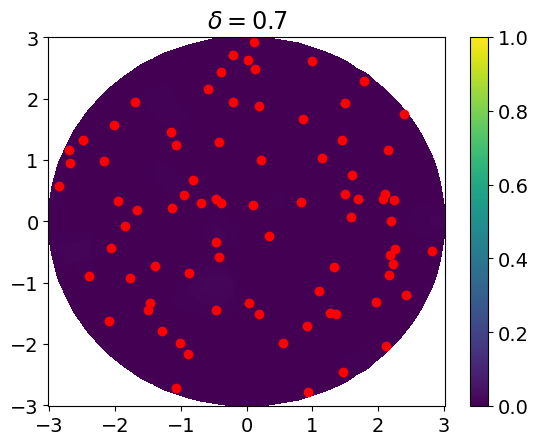

Mean square error: tensor(0.0654)
L-infinity error: tensor(1.0776)


100%|██████████| 500/500 [00:10<00:00, 48.54it/s]


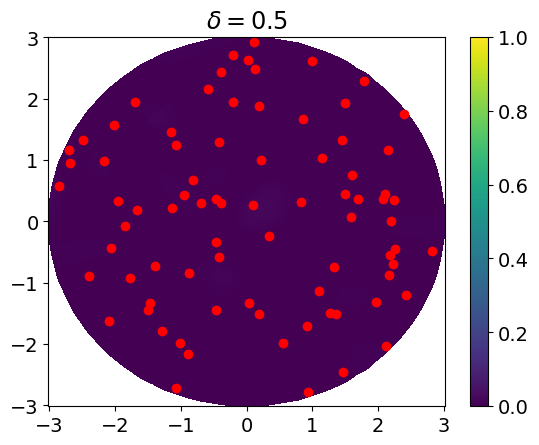

Mean square error: tensor(0.0332)
L-infinity error: tensor(0.8758)


100%|██████████| 500/500 [00:10<00:00, 47.77it/s]


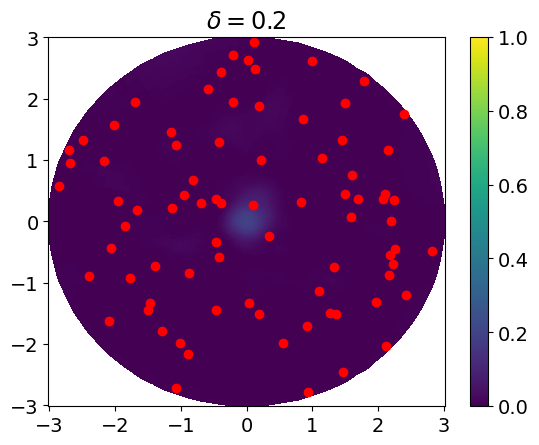

Mean square error: tensor(0.0057)
L-infinity error: tensor(0.5184)


100%|██████████| 500/500 [00:10<00:00, 47.14it/s]


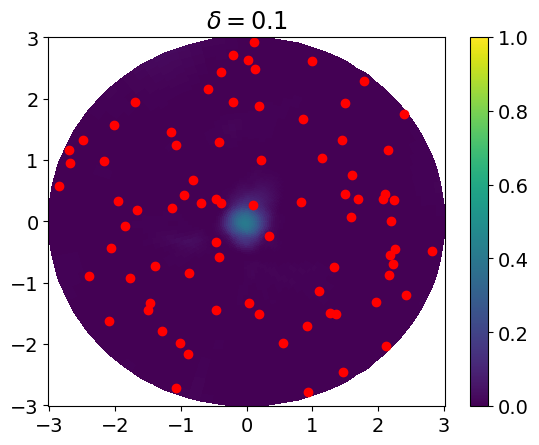

Mean square error: tensor(0.0019)
L-infinity error: tensor(0.3751)


100%|██████████| 500/500 [00:10<00:00, 49.42it/s]


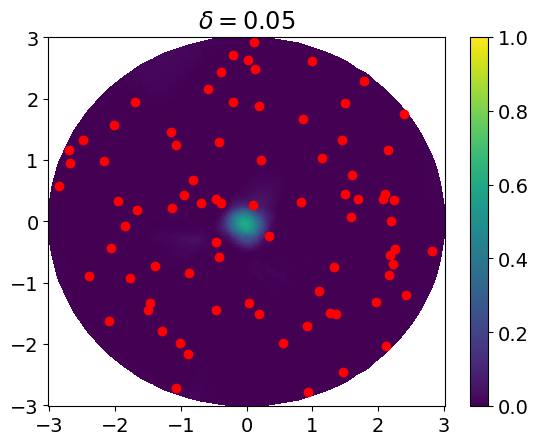

Mean square error: tensor(0.0011)
L-infinity error: tensor(0.2915)


100%|██████████| 500/500 [00:10<00:00, 48.96it/s]


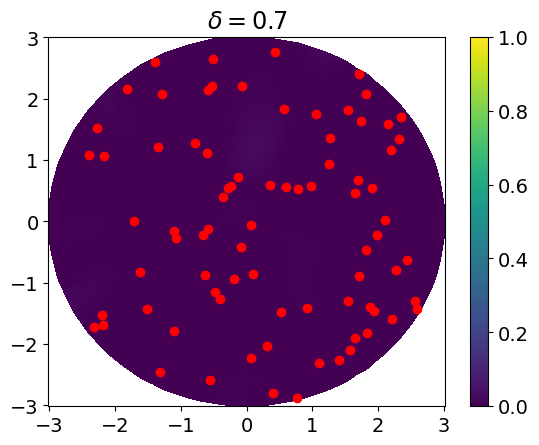

Mean square error: tensor(0.0672)
L-infinity error: tensor(1.0884)


100%|██████████| 500/500 [00:10<00:00, 47.55it/s]


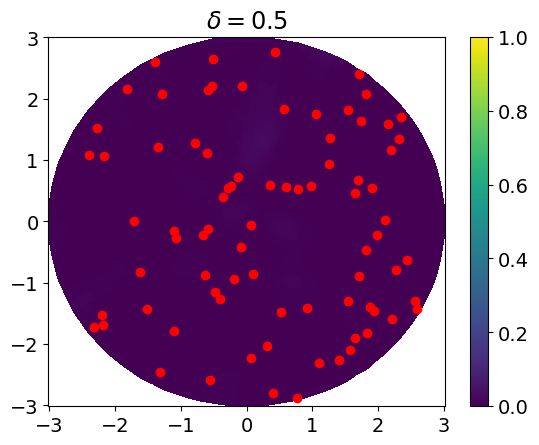

Mean square error: tensor(0.0332)
L-infinity error: tensor(0.8683)


100%|██████████| 500/500 [00:09<00:00, 50.24it/s]


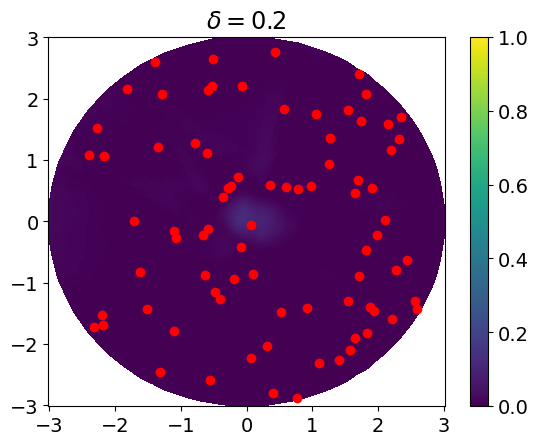

Mean square error: tensor(0.0055)
L-infinity error: tensor(0.4996)


100%|██████████| 500/500 [00:10<00:00, 48.50it/s]


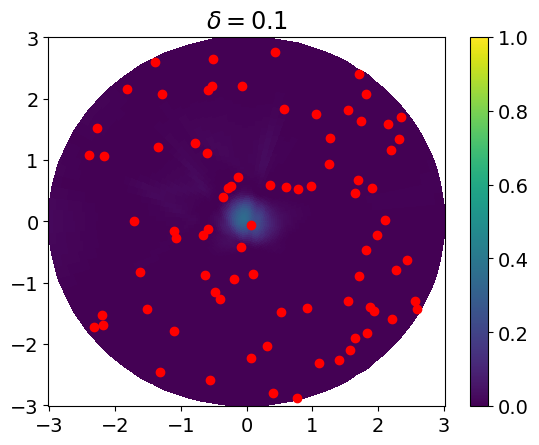

Mean square error: tensor(0.0019)
L-infinity error: tensor(0.3622)


100%|██████████| 500/500 [00:10<00:00, 48.29it/s]


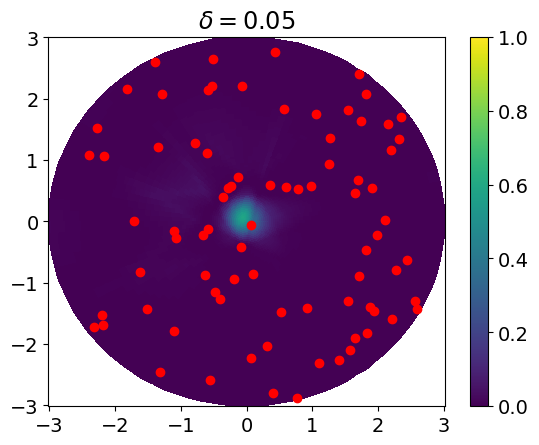

Mean square error: tensor(0.0017)
L-infinity error: tensor(0.2994)


In [2]:
MSE_history1 = torch.zeros([n_experiments, rounds])
L_inf_error_history1 = torch.zeros([n_experiments, rounds]) 

training_error_history1 = torch.zeros([n_experiments, rounds])
test_error_history1 = torch.zeros([n_experiments, rounds])

training_error_history1_max = torch.zeros([n_experiments, rounds])
test_error_history1_max = torch.zeros([n_experiments, rounds])


for j in range(n_experiments):
    # We initialise the NN
    NN1 = FCFF_3L_ELU([dim,20,20])
    training_params['optimizer'] = optim.SGD(NN1.parameters(), lr = .01, momentum = .2)

    training_params['numerical_scheme'] = Eikonal_sq_LF_multiD
    
    ## Here we sample the collocation points and the boundary points.
    training_data_int = domain.rand_int_points(0., 80)
    training_data_bound = domain.rand_bound_points(40)
    
    training_params['epochs'] = 500
    training_params['batch_size'] = 20

    
    for i in range(rounds):

        training_params['alpha'] = alpha_list[i]
        training_params['delta'] = delta_list[i]
        
        total_loss, PDE_loss, boundary_loss = train_finite_sum(NN1, training_data_int, 
                                                               training_data_bound, training_params)

        MC_points = int(1e5) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_ball(NN1, max(radii), MC_points, display = False)
        
        with torch.no_grad():
            training_error = FD_loss(NN1, training_data_int, training_params)
            test_error = FD_loss(NN1, test_data, training_params)
        
        training_error_history1[j,i] = training_error.mean()
        test_error_history1[j,i] = test_error.mean()
        training_error_history1_max[j,i] = training_error.max().item()
        test_error_history1_max[j,i] = test_error.max().item()
        
        MSE_history1[j,i] = MSE
        L_inf_error_history1[j,i] = L_inf
    
        #epochs =  training_params['epochs']
        #plt.plot(torch.arange(epochs)+1, total_loss)
        #plt.plot(torch.arange(epochs)+1, PDE_loss)
        #plt.plot(torch.arange(epochs)+1, boundary_loss)
        #plt.legend(labels=['Total loss', 'PDE loss', 'BC loss'])
        #plt.show()
        
        X_axis = 0
        Y_axis = 1
        n_grid = 100
        
        #plot_2d_proj_disc(X_axis, Y_axis, NN1, n_grid, n_grid, radii)
        plot_2d_proj_w(X_axis, Y_axis, NN1, n_grid, radii, training_params,training_data_int)
        
        print('Mean square error:', MSE)
        print('L-infinity error:', L_inf)

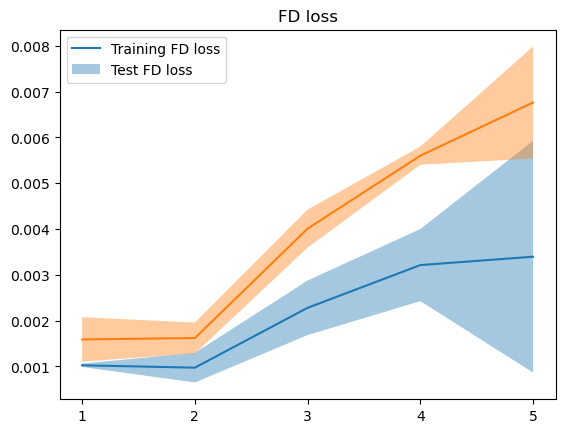

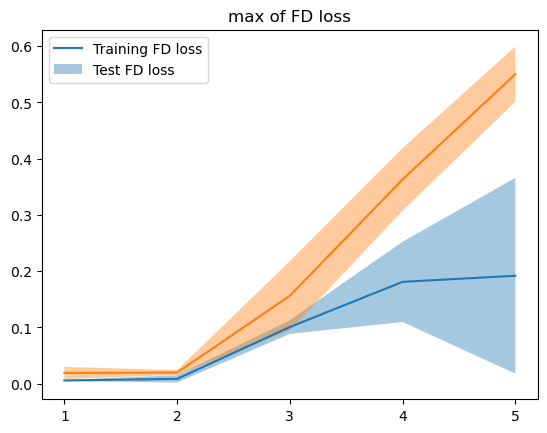

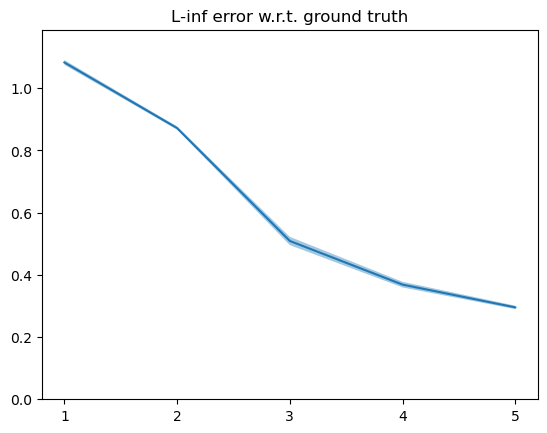

In [3]:
plt.plot(np.arange(rounds) , training_error_history1.mean(0))
plt.fill_between(np.arange(rounds) , 
                 training_error_history1.mean(0) - training_error_history1.std(0), 
                training_error_history1.mean(0) + training_error_history1.std(0), alpha=0.4)

plt.plot(np.arange(rounds) , test_error_history1.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history1.mean(0) - test_error_history1.std(0),
                test_error_history1.mean(0) + test_error_history1.std(0), alpha = 0.4)

plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('FD loss')
plt.show()

plt.plot(np.arange(rounds) , training_error_history1_max.mean(0))
plt.fill_between(np.arange(rounds),
                 training_error_history1_max.mean(0) - training_error_history1_max.std(0),
                training_error_history1_max.mean(0) + training_error_history1_max.std(0),
                alpha = .4)

plt.plot(np.arange(rounds) , test_error_history1_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history1_max.mean(0) - test_error_history1_max.std(0),
                test_error_history1_max.mean(0) + test_error_history1_max.std(0),
                alpha = .4)
#plt.ylim(0, test_error_history1_max.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history1.mean(0))
plt.fill_between(np.arange(rounds),
                L_inf_error_history1.mean(0) - L_inf_error_history1.std(0),
                L_inf_error_history1.mean(0) + L_inf_error_history1.std(0),
                alpha = .4)

plt.ylim(0, L_inf_error_history1.max().item()+0.1)
plt.title('L-inf error w.r.t. ground truth')
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.show()

# Fixed collocation points and Autograd Hamiltonian

100%|██████████| 500/500 [00:53<00:00,  9.43it/s]
C:\Users\usuario\Documents\math\project_FD_PINNs\HamiltonJacobi_LeastSquares_LxF_NNs\Notebooks_revised\..\visualization\disc_training.py:48: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


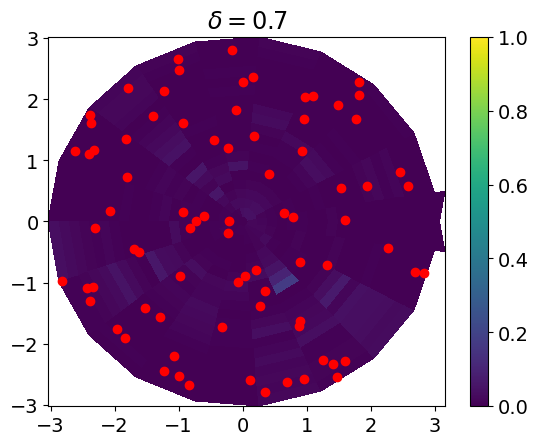

Mean square error: tensor(0.1491)
L-infinity error: tensor(1.4075)


100%|██████████| 500/500 [00:37<00:00, 13.50it/s]


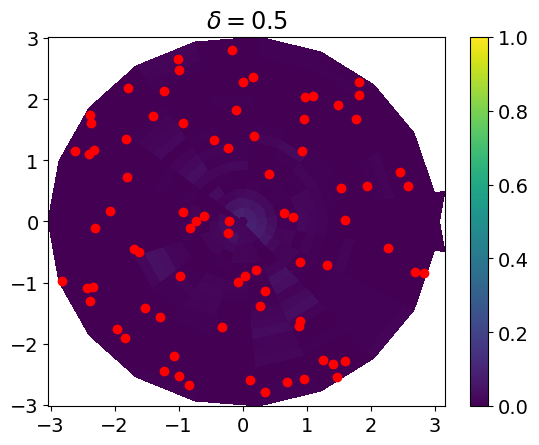

Mean square error: tensor(0.0398)
L-infinity error: tensor(0.9497)


100%|██████████| 500/500 [00:21<00:00, 22.96it/s]


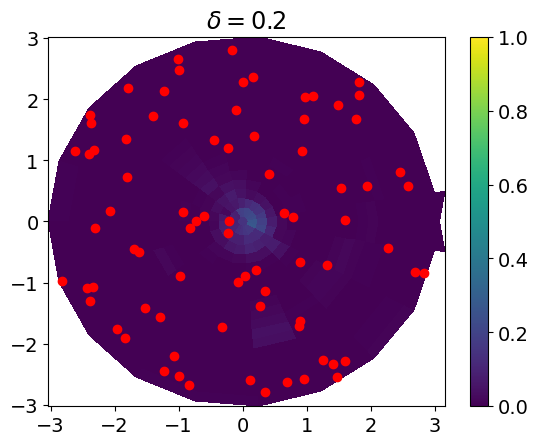

Mean square error: tensor(0.0075)
L-infinity error: tensor(0.5508)


100%|██████████| 500/500 [00:21<00:00, 22.74it/s]


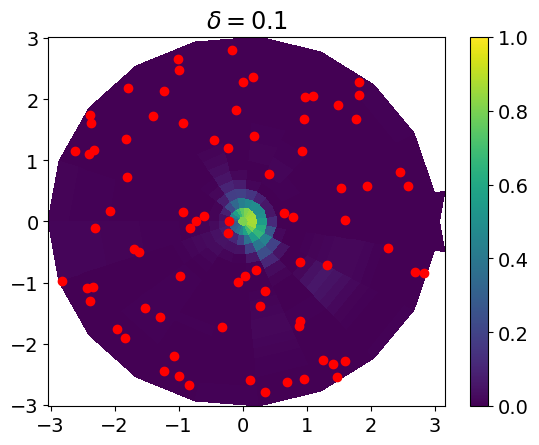

Mean square error: tensor(0.0059)
L-infinity error: tensor(0.2879)


100%|██████████| 500/500 [00:03<00:00, 143.86it/s]


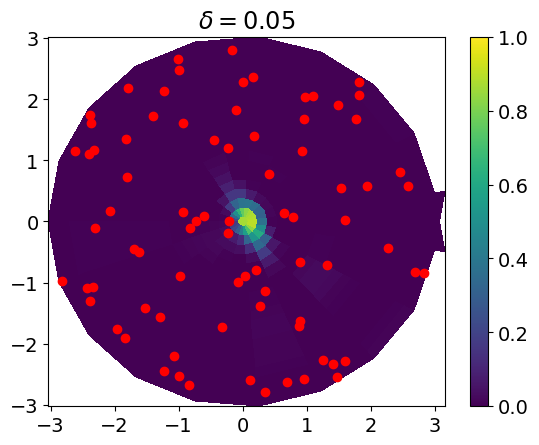

Mean square error: tensor(0.0053)
L-infinity error: tensor(0.2468)


100%|██████████| 500/500 [00:21<00:00, 22.79it/s]


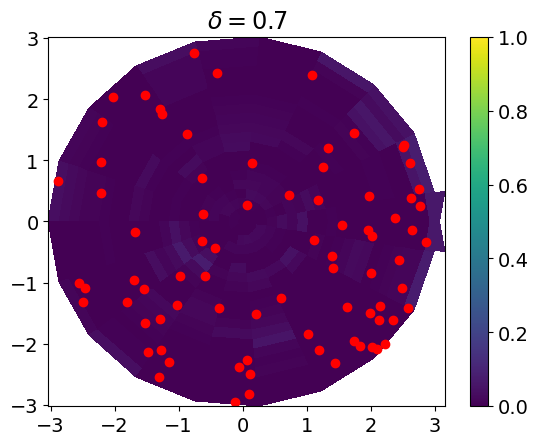

Mean square error: tensor(0.1624)
L-infinity error: tensor(1.4455)


100%|██████████| 500/500 [00:21<00:00, 23.12it/s]


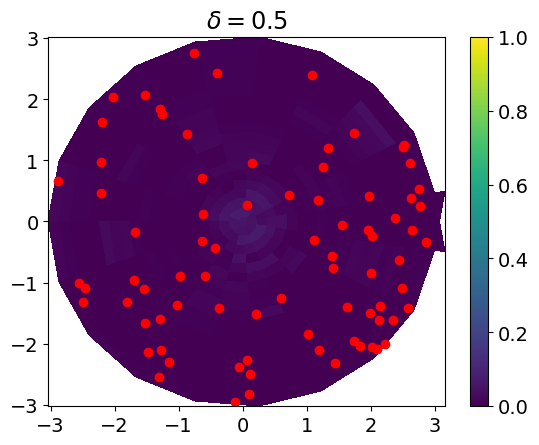

Mean square error: tensor(0.0445)
L-infinity error: tensor(0.9750)


100%|██████████| 500/500 [00:21<00:00, 23.34it/s]


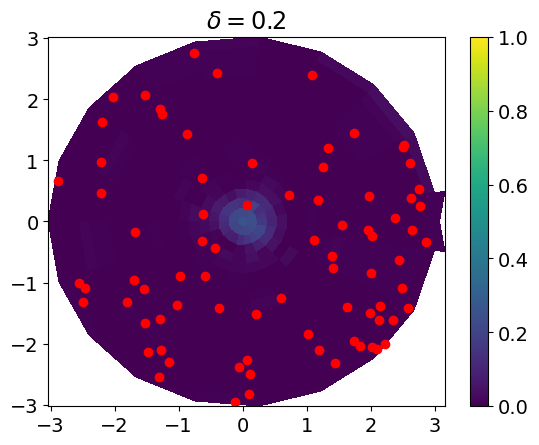

Mean square error: tensor(0.0099)
L-infinity error: tensor(0.5999)


100%|██████████| 500/500 [00:21<00:00, 22.87it/s]


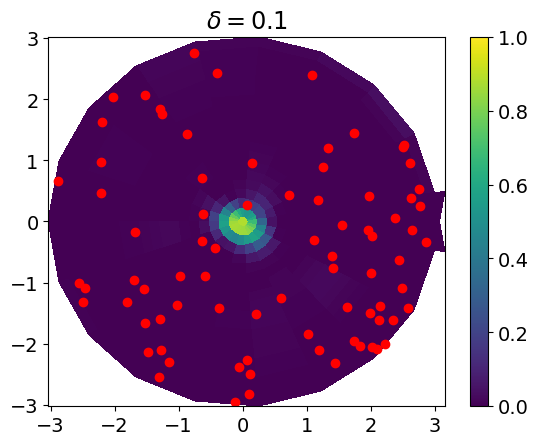

Mean square error: tensor(0.0017)
L-infinity error: tensor(0.2975)


100%|██████████| 500/500 [00:03<00:00, 145.62it/s]


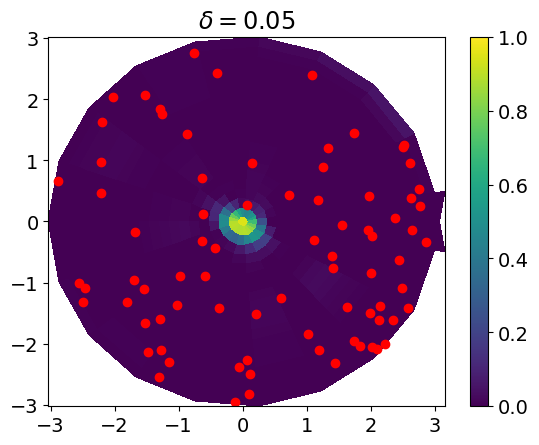

Mean square error: tensor(0.0018)
L-infinity error: tensor(0.2487)


In [4]:
MSE_history2 = torch.zeros([n_experiments, rounds])
L_inf_error_history2 = torch.zeros([n_experiments, rounds]) 

training_error_history2 = torch.zeros([n_experiments, rounds])
test_error_history2 = torch.zeros([n_experiments, rounds])

training_error_history2_max = torch.zeros([n_experiments, rounds])
test_error_history2_max = torch.zeros([n_experiments, rounds])


for j in range(n_experiments):
    # We initialise the NN
    NN2 = FCFF_3L_ELU([dim,20,20])
    training_params['optimizer'] = optim.SGD(NN2.parameters(), lr = .01, momentum = .2)

    training_params['numerical_scheme'] = Eikonal_sq_autograd
    
    ## Here we sample the collocation points and the boundary points.
    training_data_int = domain.rand_int_points(0., 80)
    training_data_bound = domain.rand_bound_points(40)
    
    training_params['epochs'] = 500
    training_params['batch_size'] = 20

    
    for i in range(rounds):
    
        training_params['alpha'] = epsilon_list[i]
        # In this case delta is unused
        training_params['delta'] = delta_list[i]
        
        total_loss, PDE_loss, boundary_loss = train_finite_sum(NN2, training_data_int, 
                                                               training_data_bound, training_params)

        MC_points = int(1e5) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_ball(NN2, max(radii), MC_points, display = False)
        
        with torch.no_grad():
            training_error = FD_loss(NN2, training_data_int, training_params)
            test_error = FD_loss(NN2, test_data, training_params)
        
        training_error_history2[j,i] = training_error.mean()
        test_error_history2[j,i] = test_error.mean()
        training_error_history2_max[j,i] = training_error.max().item()
        test_error_history2_max[j,i] = test_error.max().item()
        
        MSE_history2[j,i] = MSE
        L_inf_error_history2[j,i] = L_inf
    
        #epochs =  training_params['epochs']
        #plt.plot(torch.arange(epochs)+1, total_loss)
        #plt.plot(torch.arange(epochs)+1, PDE_loss)
        #plt.plot(torch.arange(epochs)+1, boundary_loss)
        #plt.legend(labels=['Total loss', 'PDE loss', 'BC loss'])
        #plt.show()
        
        X_axis = 0
        Y_axis = 1
        n_grid = 20
                        
        plot_2d_proj_w(X_axis, Y_axis, NN2, n_grid, radii, training_params,training_data_int)
        
        print('Mean square error:', MSE)
        print('L-infinity error:', L_inf)

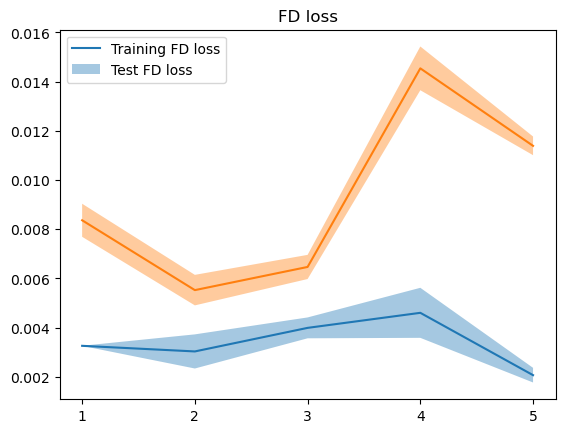

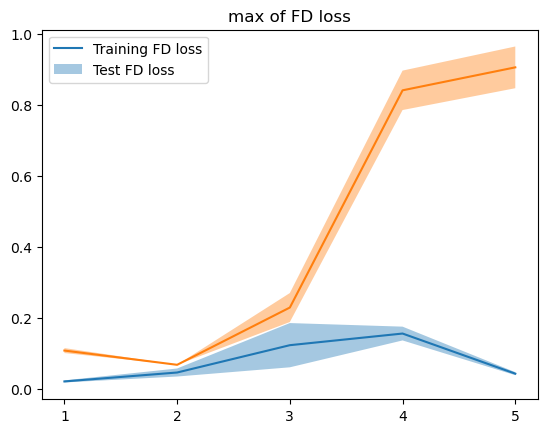

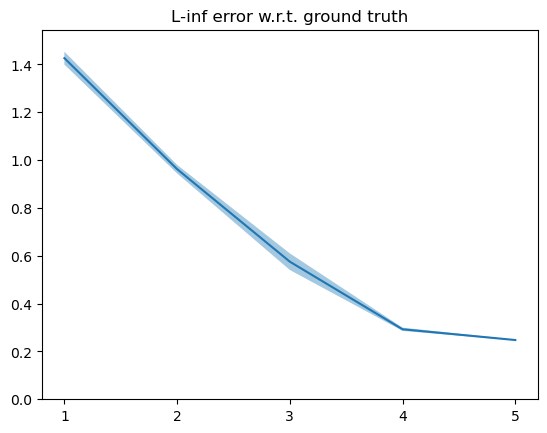

In [5]:
plt.plot(np.arange(rounds) , training_error_history2.mean(0))
plt.fill_between(np.arange(rounds) , 
                 training_error_history2.mean(0) - training_error_history2.std(0), 
                training_error_history2.mean(0) + training_error_history2.std(0), alpha=0.4)

plt.plot(np.arange(rounds) , test_error_history2.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history2.mean(0) - test_error_history2.std(0),
                test_error_history2.mean(0) + test_error_history2.std(0), alpha = 0.4)

plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('FD loss')
plt.show()

plt.plot(np.arange(rounds) , training_error_history2_max.mean(0))
plt.fill_between(np.arange(rounds),
                 training_error_history2_max.mean(0) - training_error_history2_max.std(0),
                training_error_history2_max.mean(0) + training_error_history2_max.std(0),
                alpha = .4)

plt.plot(np.arange(rounds) , test_error_history2_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history2_max.mean(0) - test_error_history2_max.std(0),
                test_error_history2_max.mean(0) + test_error_history2_max.std(0),
                alpha = .4)
#plt.ylim(0, test_error_history1_max.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history2.mean(0))
plt.fill_between(np.arange(rounds),
                L_inf_error_history2.mean(0) - L_inf_error_history2.std(0),
                L_inf_error_history2.mean(0) + L_inf_error_history2.std(0),
                alpha = .4)

plt.ylim(0, L_inf_error_history2.max().item()+0.1)
plt.title('L-inf error w.r.t. ground truth')
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.show()

# Re-sampling and Lax-Friedrichs numerical Hamltonian

100%|██████████| 2500/2500 [00:02<00:00, 1124.07it/s]
C:\Users\usuario\Documents\math\project_FD_PINNs\HamiltonJacobi_LeastSquares_LxF_NNs\Notebooks_revised\..\visualization\disc_training.py:48: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


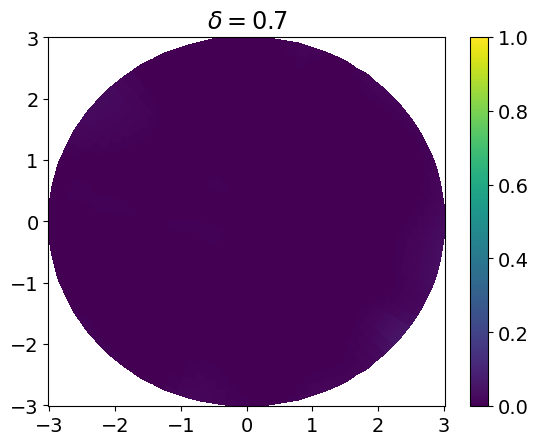

Mean square error: tensor(0.0675)
L-infinity error: tensor(1.0777)


100%|██████████| 2500/2500 [00:02<00:00, 1147.56it/s]


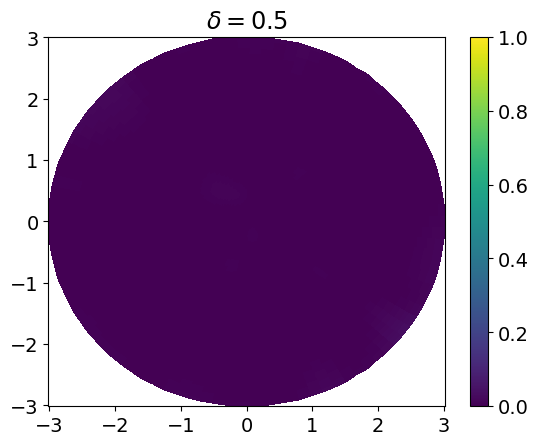

Mean square error: tensor(0.0348)
L-infinity error: tensor(0.8709)


100%|██████████| 2500/2500 [00:02<00:00, 1112.88it/s]


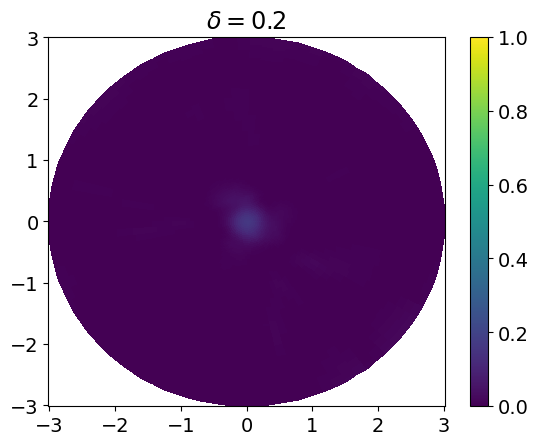

Mean square error: tensor(0.0059)
L-infinity error: tensor(0.5111)


100%|██████████| 2500/2500 [00:02<00:00, 1127.78it/s]


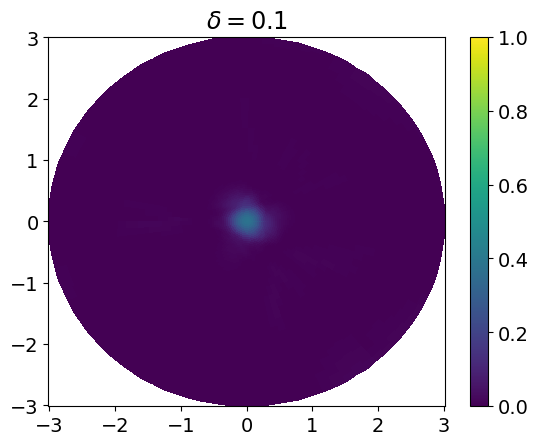

Mean square error: tensor(0.0019)
L-infinity error: tensor(0.3661)


100%|██████████| 2500/2500 [00:02<00:00, 1136.65it/s]


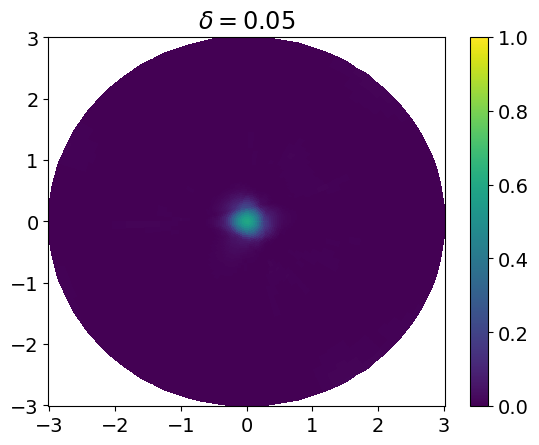

Mean square error: tensor(0.0007)
L-infinity error: tensor(0.2826)


100%|██████████| 2500/2500 [00:02<00:00, 1119.91it/s]


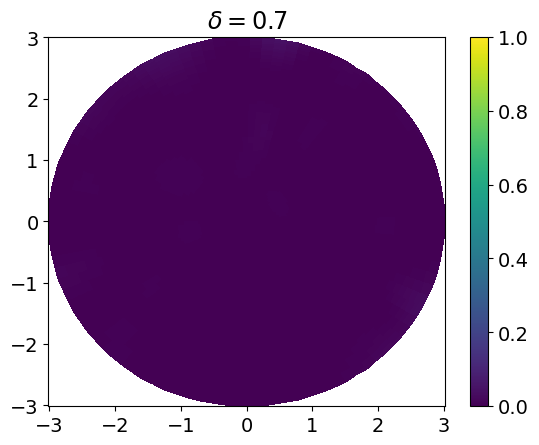

Mean square error: tensor(0.0637)
L-infinity error: tensor(1.0743)


100%|██████████| 2500/2500 [00:02<00:00, 1121.89it/s]


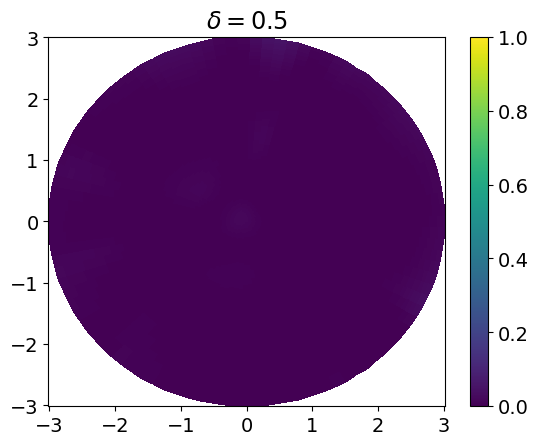

Mean square error: tensor(0.0347)
L-infinity error: tensor(0.8813)


100%|██████████| 2500/2500 [00:02<00:00, 1136.15it/s]


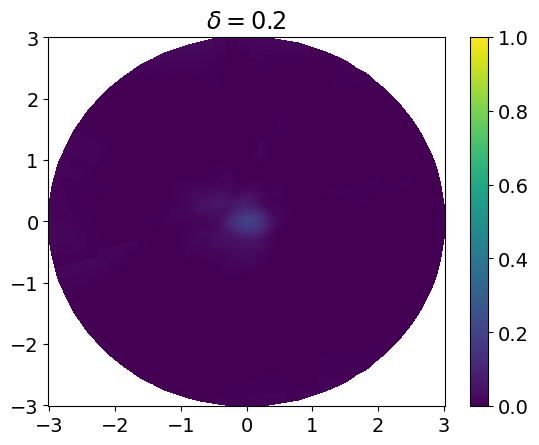

Mean square error: tensor(0.0069)
L-infinity error: tensor(0.5407)


100%|██████████| 2500/2500 [00:02<00:00, 1171.80it/s]


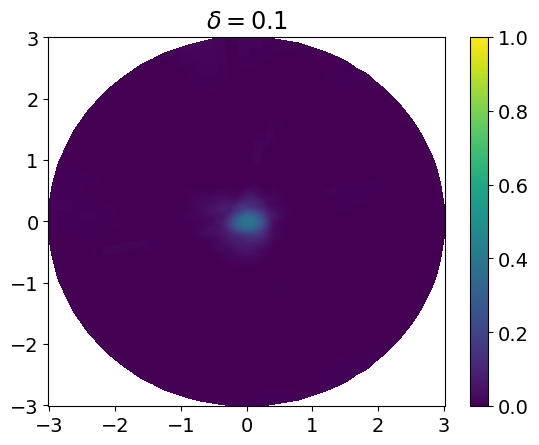

Mean square error: tensor(0.0031)
L-infinity error: tensor(0.3964)


100%|██████████| 2500/2500 [00:02<00:00, 1172.58it/s]


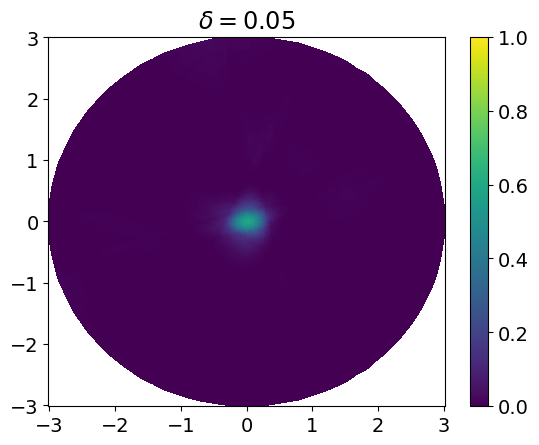

Mean square error: tensor(0.0009)
L-infinity error: tensor(0.2870)


In [6]:
MSE_history3 = torch.zeros([n_experiments, rounds])
L_inf_error_history3 = torch.zeros([n_experiments, rounds]) 

training_error_history3 = torch.zeros([n_experiments, rounds])
test_error_history3 = torch.zeros([n_experiments, rounds])

test_error_history3_max = torch.zeros([n_experiments, rounds])

from Training.training import train

training_params['n_coloc_points'] = 20
training_params['n_boundary_points'] = 8
n_ite = 2500
training_params['num_iterations'] = n_ite

for j in range(n_experiments):
    # We initialise the NN
    NN3 = FCFF_3L_ELU([dim,20,20])
    training_params['optimizer'] = optim.SGD(NN3.parameters(), lr = .01, momentum = .2)

    training_params['numerical_scheme'] = Eikonal_sq_LF_multiD
    
    training_params['epochs'] = 500
    training_params['batch_size'] = 20

    
    for i in range(rounds):
    
        training_params['alpha'] = alpha_list[i]
        training_params['delta'] = delta_list[i]

        total_loss, PDE_loss, boundary_loss = train(NN3, domain, training_params)

        MC_points = int(1e5) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_ball(NN3, max(radii), MC_points, display = False)
        
        with torch.no_grad():
            #training_error = FD_loss(NN2, training_data_int, training_params)
            test_error = FD_loss(NN3, test_data, training_params)
        
        training_error_history3[j,i] = PDE_loss[-1]
        test_error_history3[j,i] = test_error.mean()
        test_error_history3_max[j,i] = test_error.max().item()
        
        MSE_history3[j,i] = MSE
        L_inf_error_history3[j,i] = L_inf
    
        #epochs =  training_params['epochs']
        #plt.plot(torch.arange(n_ite)+1, total_loss)
        #plt.plot(torch.arange(n_ite)+1, PDE_loss)
        #plt.plot(torch.arange(n_ite)+1, boundary_loss)
        #plt.legend(labels=['Total loss', 'PDE loss', 'BC loss'])
        #plt.show()
        
        X_axis = 0
        Y_axis = 1
        n_grid = 100
        
        plot_2d_proj_w(X_axis, Y_axis, NN3, n_grid, radii, training_params)
        
        print('Mean square error:', MSE)
        print('L-infinity error:', L_inf)

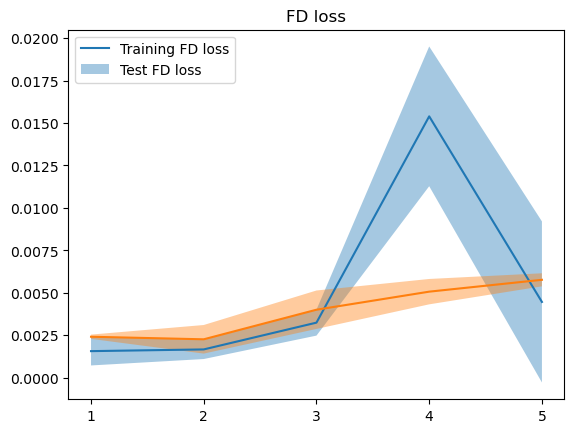

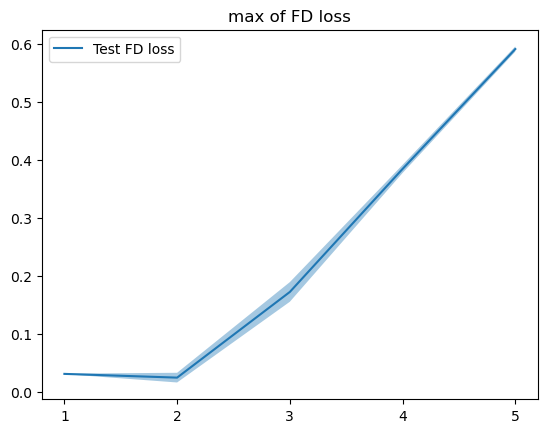

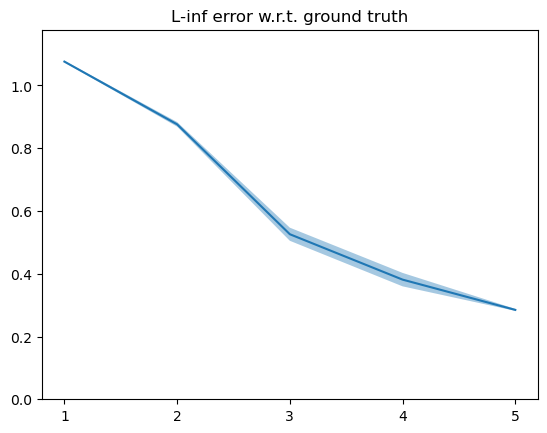

In [7]:
plt.plot(np.arange(rounds) , training_error_history3.mean(0))
plt.fill_between(np.arange(rounds) , 
                 training_error_history3.mean(0) - training_error_history3.std(0), 
                training_error_history3.mean(0) + training_error_history3.std(0), alpha=0.4)

plt.plot(np.arange(rounds) , test_error_history3.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history3.mean(0) - test_error_history3.std(0),
                test_error_history3.mean(0) + test_error_history3.std(0), alpha = 0.4)

plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('FD loss')
plt.show()

plt.plot(np.arange(rounds) , test_error_history3_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history3_max.mean(0) - test_error_history3_max.std(0),
                test_error_history3_max.mean(0) + test_error_history3_max.std(0),
                alpha = .4)
plt.legend(labels = ['Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history3.mean(0))
plt.fill_between(np.arange(rounds),
                L_inf_error_history3.mean(0) - L_inf_error_history3.std(0),
                L_inf_error_history3.mean(0) + L_inf_error_history3.std(0),
                alpha = .4)

plt.ylim(0, L_inf_error_history3.max().item()+0.1)
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('L-inf error w.r.t. ground truth')
plt.show()

# Re-sampling and Autograd Hamltonian

100%|██████████| 2500/2500 [00:24<00:00, 101.78it/s]
C:\Users\usuario\Documents\math\project_FD_PINNs\HamiltonJacobi_LeastSquares_LxF_NNs\Notebooks_revised\..\visualization\disc_training.py:48: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


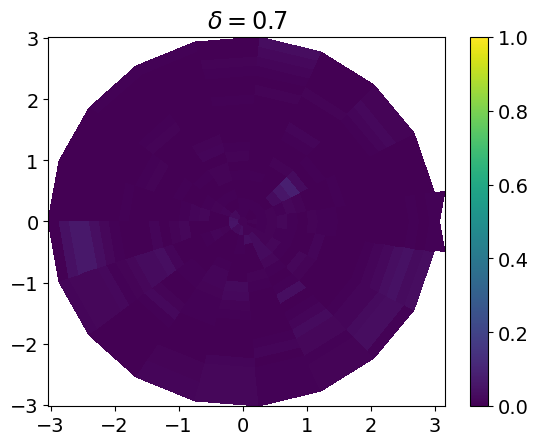

Mean square error: tensor(0.1540)
L-infinity error: tensor(1.4228)


100%|██████████| 2500/2500 [00:24<00:00, 100.60it/s]


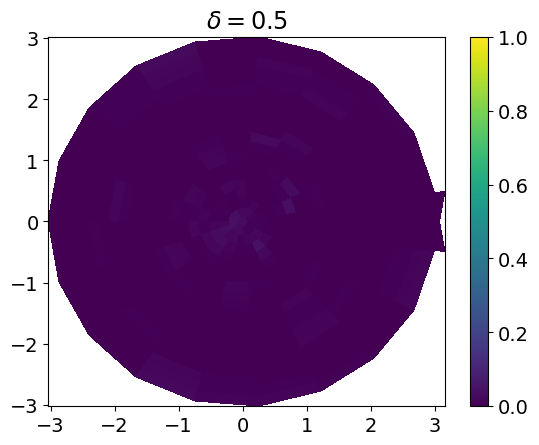

Mean square error: tensor(0.0406)
L-infinity error: tensor(0.9280)


100%|██████████| 2500/2500 [00:24<00:00, 102.93it/s]


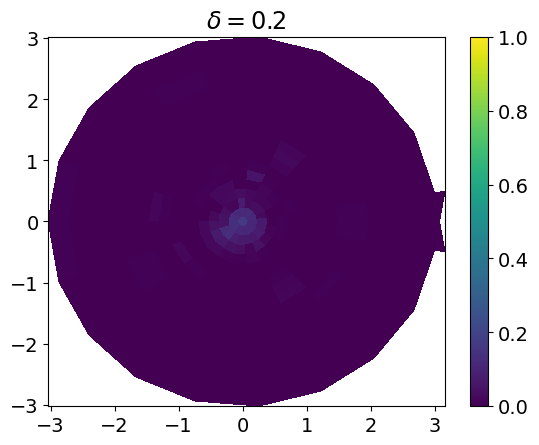

Mean square error: tensor(0.0070)
L-infinity error: tensor(0.5318)


100%|██████████| 2500/2500 [00:24<00:00, 102.01it/s]


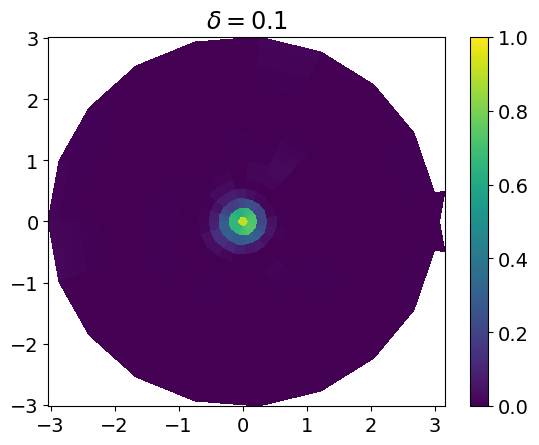

Mean square error: tensor(0.0006)
L-infinity error: tensor(0.2571)


100%|██████████| 2500/2500 [00:01<00:00, 1361.09it/s]


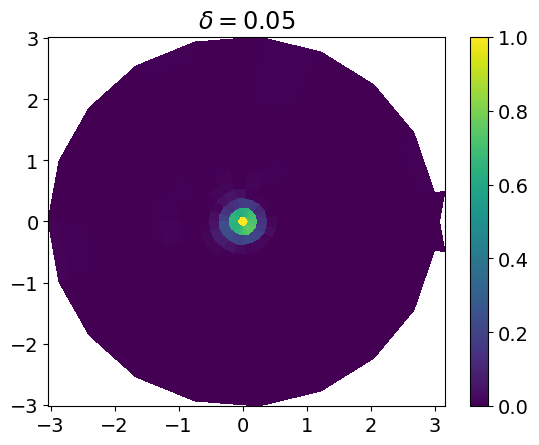

Mean square error: tensor(0.0003)
L-infinity error: tensor(0.2169)


100%|██████████| 2500/2500 [00:25<00:00, 99.11it/s] 


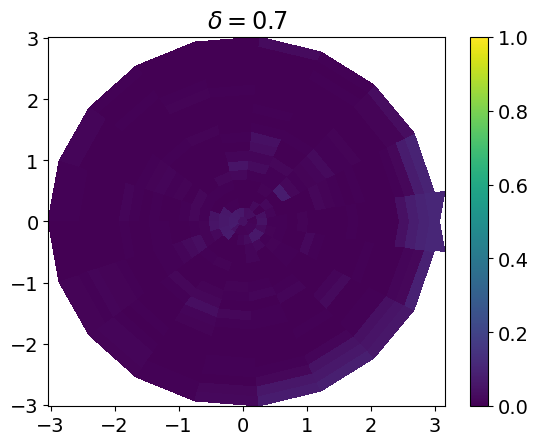

Mean square error: tensor(0.1620)
L-infinity error: tensor(1.4474)


100%|██████████| 2500/2500 [00:24<00:00, 101.90it/s]


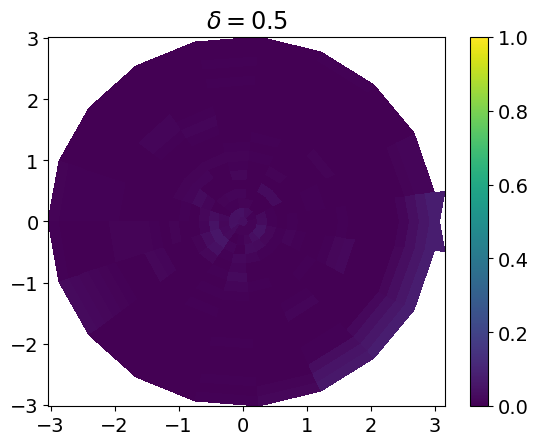

Mean square error: tensor(0.0436)
L-infinity error: tensor(0.9491)


100%|██████████| 2500/2500 [00:24<00:00, 102.57it/s]


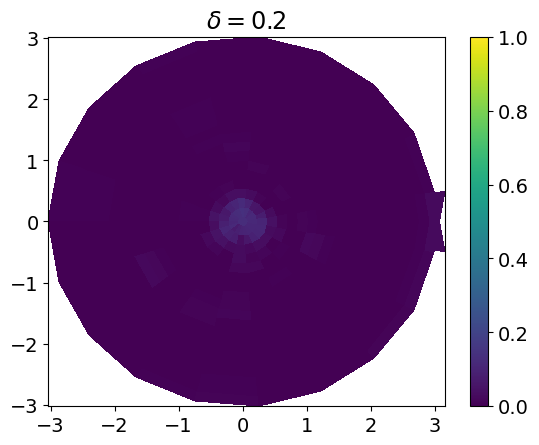

Mean square error: tensor(0.0074)
L-infinity error: tensor(0.5369)


100%|██████████| 2500/2500 [00:24<00:00, 102.74it/s]


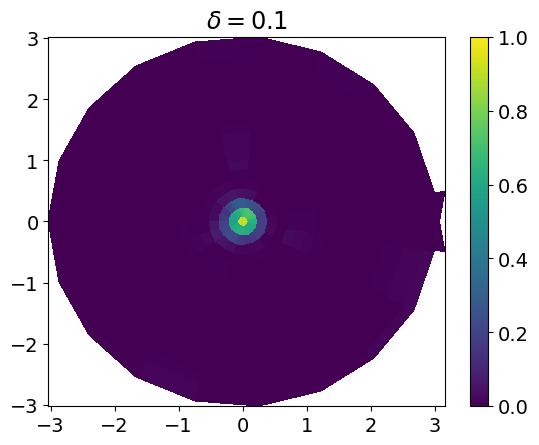

Mean square error: tensor(0.0006)
L-infinity error: tensor(0.2443)


100%|██████████| 2500/2500 [00:01<00:00, 1311.96it/s]


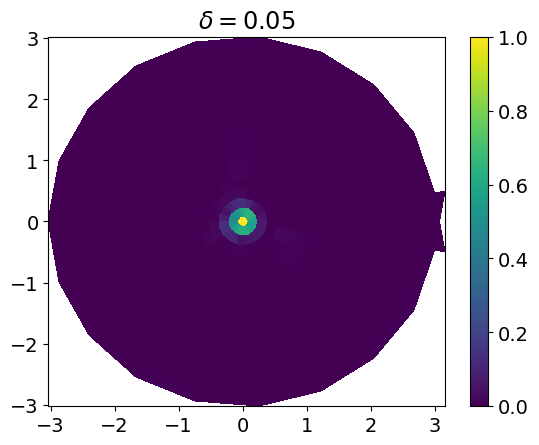

Mean square error: tensor(0.0003)
L-infinity error: tensor(0.1760)


In [8]:
MSE_history4 = torch.zeros([n_experiments, rounds])
L_inf_error_history4 = torch.zeros([n_experiments, rounds]) 

training_error_history4 = torch.zeros([n_experiments, rounds])
test_error_history4 = torch.zeros([n_experiments, rounds])

test_error_history4_max = torch.zeros([n_experiments, rounds])

from Training.training import train

training_params['n_coloc_points'] = 20
training_params['n_boundary_points'] = 8
n_ite = 2500
training_params['num_iterations'] = n_ite

for j in range(n_experiments):
    # We initialise the NN
    NN4 = FCFF_3L_ELU([dim,20,20])
    training_params['optimizer'] = optim.SGD(NN4.parameters(), lr = .01, momentum = .2)

    training_params['numerical_scheme'] = Eikonal_sq_autograd
    
    training_params['epochs'] = 500
    training_params['batch_size'] = 20

    
    for i in range(rounds):
    
        training_params['alpha'] = epsilon_list[i]
        # In this case delta is unused
        training_params['delta'] = delta_list[i]

        total_loss, PDE_loss, boundary_loss = train(NN4, domain, training_params)

        MC_points = int(1e5) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_ball(NN4, max(radii), MC_points, display = False)
        
        with torch.no_grad():
            #training_error = FD_loss(NN2, training_data_int, training_params)
            test_error = FD_loss(NN4, test_data, training_params)
        
        training_error_history4[j,i] = PDE_loss[-1]
        test_error_history4[j,i] = test_error.mean()
        test_error_history4_max[j,i] = test_error.max().item()
        
        MSE_history4[j,i] = MSE
        L_inf_error_history4[j,i] = L_inf
    
        #epochs =  training_params['epochs']
        #plt.plot(torch.arange(n_ite)+1, total_loss)
        #plt.plot(torch.arange(n_ite)+1, PDE_loss)
        #plt.plot(torch.arange(n_ite)+1, boundary_loss)
        #plt.legend(labels=['Total loss', 'PDE loss', 'BC loss'])
        #plt.show()
        
        X_axis = 0
        Y_axis = 1
        n_grid = 20
        
        plot_2d_proj_w(X_axis, Y_axis, NN4, n_grid, radii, training_params)
        
        print('Mean square error:', MSE)
        print('L-infinity error:', L_inf)

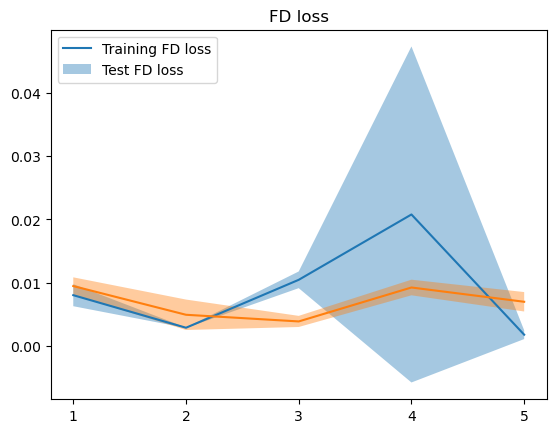

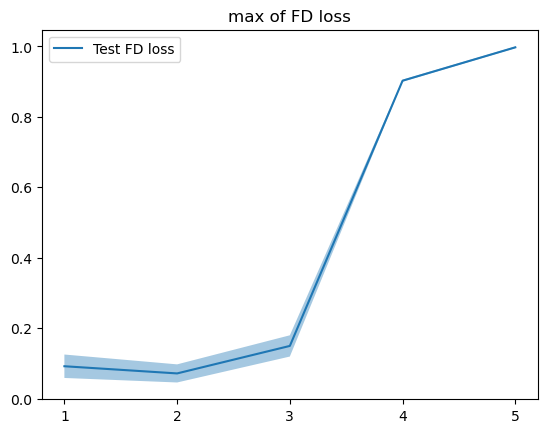

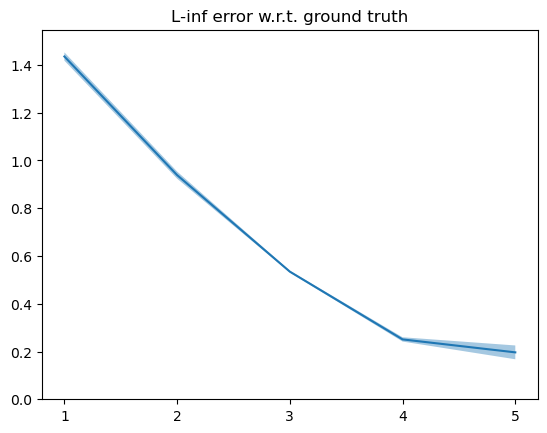

In [9]:
plt.plot(np.arange(rounds) , training_error_history4.mean(0))
plt.fill_between(np.arange(rounds) , 
                 training_error_history4.mean(0) - training_error_history4.std(0), 
                training_error_history4.mean(0) + training_error_history4.std(0), alpha=0.4)

plt.plot(np.arange(rounds) , test_error_history4.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history4.mean(0) - test_error_history4.std(0),
                test_error_history4.mean(0) + test_error_history4.std(0), alpha = 0.4)

plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('FD loss')
plt.show()

plt.plot(np.arange(rounds) , test_error_history4_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history4_max.mean(0) - test_error_history4_max.std(0),
                test_error_history4_max.mean(0) + test_error_history4_max.std(0),
                alpha = .4)
plt.legend(labels = ['Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history4.mean(0))
plt.fill_between(np.arange(rounds),
                L_inf_error_history4.mean(0) - L_inf_error_history4.std(0),
                L_inf_error_history4.mean(0) + L_inf_error_history4.std(0),
                alpha = .4)

plt.ylim(0, L_inf_error_history4.max().item()+0.1)
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('L-inf error w.r.t. ground truth')
plt.show()

# Comparison

<>:92: SyntaxWarning: invalid escape sequence '\l'
<>:125: SyntaxWarning: invalid escape sequence '\l'
<>:92: SyntaxWarning: invalid escape sequence '\l'
<>:125: SyntaxWarning: invalid escape sequence '\l'
C:\Users\usuario\AppData\Local\Temp\ipykernel_22280\988486548.py:92: SyntaxWarning: invalid escape sequence '\l'
  plt.title('$\log_{10} (MSE)$', fontsize = 'xx-large')
C:\Users\usuario\AppData\Local\Temp\ipykernel_22280\988486548.py:125: SyntaxWarning: invalid escape sequence '\l'
  plt.title('$\log_{10} (E_{\infty})$', fontsize = 'xx-large')


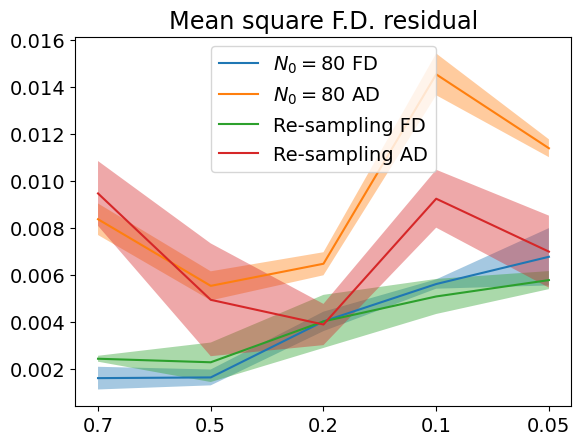

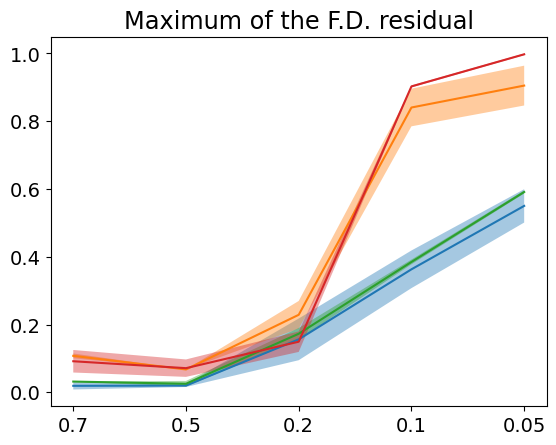

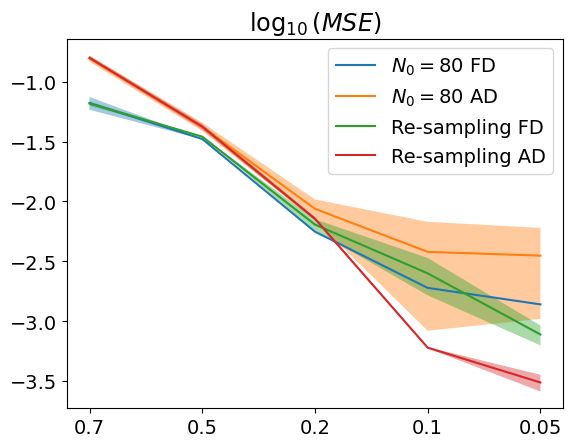

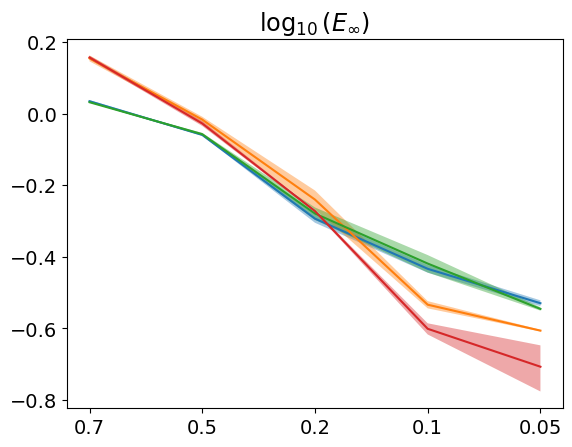

In [10]:
plt.plot(np.arange(rounds) , test_error_history1.mean(0))
plt.plot(np.arange(rounds) , test_error_history2.mean(0))
plt.plot(np.arange(rounds) , test_error_history3.mean(0))
plt.plot(np.arange(rounds) , test_error_history4.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history1.mean(0) - test_error_history1.std(0),
                test_error_history1.mean(0) + test_error_history1.std(0), alpha = 0.4)

plt.fill_between(np.arange(rounds), 
                test_error_history2.mean(0) - test_error_history2.std(0),
                test_error_history2.mean(0) + test_error_history2.std(0), alpha = 0.4)

plt.fill_between(np.arange(rounds), 
                test_error_history3.mean(0) - test_error_history3.std(0),
                test_error_history3.mean(0) + test_error_history3.std(0), alpha = 0.4)

plt.fill_between(np.arange(rounds), 
                test_error_history4.mean(0) - test_error_history4.std(0),
                test_error_history4.mean(0) + test_error_history4.std(0), alpha = 0.4)

plt.legend(labels = ['$N_0 = 80$ FD', '$N_0 = 80$ AD', 'Re-sampling FD', 'Re-sampling AD'], fontsize=14)
plt.xticks([i for i in range(rounds)], [ delta_list[i] for i in range(rounds)])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Mean square F.D. residual', fontsize = 'xx-large')
plt.show()


plt.plot(np.arange(rounds) , test_error_history1_max.mean(0))
plt.plot(np.arange(rounds) , test_error_history2_max.mean(0))
plt.plot(np.arange(rounds) , test_error_history3_max.mean(0))
plt.plot(np.arange(rounds) , test_error_history4_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history1_max.mean(0) - test_error_history1_max.std(0),
                test_error_history1_max.mean(0) + test_error_history1_max.std(0),
                alpha = .4)

plt.fill_between(np.arange(rounds),
                test_error_history2_max.mean(0) - test_error_history2_max.std(0),
                test_error_history2_max.mean(0) + test_error_history2_max.std(0),
                alpha = .4)

plt.fill_between(np.arange(rounds),
                test_error_history3_max.mean(0) - test_error_history3_max.std(0),
                test_error_history3_max.mean(0) + test_error_history3_max.std(0),
                alpha = .4)

plt.fill_between(np.arange(rounds),
                test_error_history4_max.mean(0) - test_error_history4_max.std(0),
                test_error_history4_max.mean(0) + test_error_history4_max.std(0),
                alpha = .4)

#plt.legend(labels = ['$N_0 = 80$', '$N_0 = 160$', 'Re-sampling'], fontsize=14)
plt.xticks([i for i in range(rounds)], [ delta_list[i] for i in range(rounds)])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Maximum of the F.D. residual', fontsize = 'xx-large')
plt.show()


plt.plot(np.arange(rounds), MSE_history1.mean(0).log10())
plt.plot(np.arange(rounds), MSE_history2.mean(0).log10())
plt.plot(np.arange(rounds), MSE_history3.mean(0).log10())
plt.plot(np.arange(rounds), MSE_history4.mean(0).log10())
plt.fill_between(np.arange(rounds),
                (MSE_history1.mean(0) - MSE_history1.log10().std(0)).log10(),
                (MSE_history1.mean(0) + MSE_history1.log10().std(0)).log10(),
                alpha = .4)

plt.fill_between(np.arange(rounds),
                (MSE_history2.mean(0) - MSE_history2.std(0)).log10(),
                (MSE_history2.mean(0) + MSE_history2.std(0)).log10(),
                alpha = .4)

plt.fill_between(np.arange(rounds),
                (MSE_history3.mean(0) - MSE_history3.std(0)).log10(),
                (MSE_history3.mean(0) + MSE_history3.std(0)).log10(),
                alpha = .4)

plt.fill_between(np.arange(rounds),
                (MSE_history4.mean(0) - MSE_history4.std(0)).log10(),
                (MSE_history4.mean(0) + MSE_history4.std(0)).log10(),
                alpha = .4)

plt.legend(labels = ['$N_0 = 80$ FD', '$N_0 = 80$ AD', 'Re-sampling FD', 'Re-sampling AD'], fontsize=14)
plt.xticks([i for i in range(rounds)], [ delta_list[i] for i in range(rounds)])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('$\log_{10} (MSE)$', fontsize = 'xx-large')
plt.show()


plt.plot(np.arange(rounds), L_inf_error_history1.mean(0).log10())
plt.plot(np.arange(rounds), L_inf_error_history2.mean(0).log10())
plt.plot(np.arange(rounds), L_inf_error_history3.mean(0).log10())
plt.plot(np.arange(rounds), L_inf_error_history4.mean(0).log10())
plt.fill_between(np.arange(rounds),
                (L_inf_error_history1.mean(0) - L_inf_error_history1.std(0)).log10(),
                (L_inf_error_history1.mean(0) + L_inf_error_history1.std(0)).log10(),
                alpha = .4)

plt.fill_between(np.arange(rounds),
                (L_inf_error_history2.mean(0) - L_inf_error_history2.std(0)).log10(),
                (L_inf_error_history2.mean(0) + L_inf_error_history2.std(0)).log10(),
                alpha = .4)

plt.fill_between(np.arange(rounds),
                (L_inf_error_history3.mean(0) - L_inf_error_history3.std(0)).log10(),
                (L_inf_error_history3.mean(0) + L_inf_error_history3.std(0)).log10(),
                alpha = .4)

plt.fill_between(np.arange(rounds),
                (L_inf_error_history4.mean(0) - L_inf_error_history4.std(0)).log10(),
                (L_inf_error_history4.mean(0) + L_inf_error_history4.std(0)).log10(),
                alpha = .4)

#plt.legend(labels = ['$N_0 = 80$', '$N_0 = 160$', 'Re-sampling'], fontsize=14)
plt.xticks([i for i in range(rounds)], [ delta_list[i] for i in range(rounds)])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('$\log_{10} (E_{\infty})$', fontsize = 'xx-large')
plt.show()